# Detección de indicadores de prejuicios de género para pedido de clarificación
> Bloc con sangría



HS: odio o no

-Si HS es 0 TR y AG no importan (dependen de el)

TR: persona o grupo de individuos(0)

AG: agresivo o no

genre_insults: misoginia o no


## Librerías

In [ ]:
!pip install es-lemmatizer
#!pip install visualise-spacy-tree
!pip3 install visualise-spacy-tree
!pip install textacy==0.10.0 pydot
!pip install nltk
###------------------------------
!pip install --user pandas progressbar2 spacy==3.1.0
!python -m spacy download es_core_news_lg --user 
!pip install --user wordcloud matplotlib
!pip install --user textacy==0.10.0 pydot
!pip install --user xlsxwriter

     |████████████████████████████████| 3.2 MB 8.5 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0
     |████████████████████████████████| 206 kB 6.8 MB/s 
     |████████████████████████████████| 2.0 MB 55.9 MB/s 
     |████████████████████████████████| 137 kB 58.9 MB/s 
     |████████████████████████████████| 481 kB 42.9 MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.2-cp37-cp37m-linux_x86_64.whl size=1231107 sha256=15002f8062bc01b9097bd58cb0c2bb02f4bcf07029e32e1f736510ffa42430d7
  Stored in directory: /root/.cache/pip/wheels/38/70/71/ca13ea3d36ccd0b3d0ec7d7a4ca67522048d695b556bba4f59
  Created wheel for jellyfish: filename=jellyfish-0.8.9-cp37-cp37m-linux_x86_64.whl size=73232 sha256=46b311d96f6ca5673a95f09cde8b458d2c2c022bb7b32493b34bc95f88a70095
  Stored in directory: /root/.cache/pip/wheels/32/a9/ef/5d8742e72deaf0d1de327a180d008c2c0299367581800ea73f
Successfully buil

In [ ]:
%matplotlib inline
import spacy.cli 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import pickle
import nltk
import os
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance
#####--------------------------
from pathlib import Path
import progressbar
import re
from IPython.display import Image, display
from textacy.extract import noun_chunks, entities
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
#------------------------------

pd.set_option('display.max_colwidth', 0)

## Dataset

### hateval2019_es_dev

In [ ]:
df_dev= pd.read_csv("/content/drive/MyDrive/4to/1-nlp/hateval2019_es_dev.csv")
df_dev.head()

,id,text,HS,TR,AG
0,20005,Me estoy comiendo la picada árabe más rica de mi vida,0,0,0
1,20006,@Haryachyzaychyk Callate zorra y mama duro! 😍,1,1,1
2,20011,"Acabo de escuchar a Casado diciendo que hay DECENAS DE MILLONES de subsaharianos ahora mismo reuniendo dinero para venir a Europa. No sé qué me asusta más, que este idiota diga esas cosas o que haya tantos tarados deseando creérselas.",0,0,0
3,20019,"""Y NADIE SE HA PREGUNTADO LO QUE LE VA A COSTAR AL HOMBRE DEL GUANTAZO LA SITUACION..?!? PORQUE SEGURO ES, QUE EL MENDA MUSULMONO LE VA A PONER UNA DENUNCIA, QUE EL FALLO VA A SER """"CULPABLE"""", QUE UNA PANDILLA DE MUSULMONOS LE VA A ESTAR ESPERANDO DELANTE DE LA PUERTA DE SU NEGOCIO https://t.co/DjfA63A0T2""",1,0,1
4,20033,"@Fed_Durand Callate come sobra, más zorra son las tuyas",1,1,1


In [ ]:
df_dev.shape

(500, 5)

### hateval2019_es_test

In [ ]:
df_test= pd.read_csv("/content/drive/MyDrive/4to/1-nlp/hateval2019_es_test.csv")
df_test.head()

,id,text,HS,TR,AG
0,31494,@jlmanavasques Tu eres un hijo de la gran puta,0,0,0
1,32461,#EnCampañaM4 Y ellos que llevan humillando al resto de España toda la puta vida que talegón bonita cállate la boqui… https://t.co/93fQkcqEla,0,0,0
2,33228,@Barbijaputa Tú sí q das vergüenza diciendo q ETA n ha matado nunca a ningún niño https://t.co/X2qiebNPRu,0,0,0
3,31699,"Vieja de mierda, te mereces todo lo que esta mal hija de mil puta, te tenés que morir prendida fuego la concha de tu hermana",1,1,1
4,33806,"@KarenB612 @SebaCaro8 Puta guede ql, callate por favor.. trabaje piola como lo has hecho hasta ahora, los resultad… https://t.co/yqrgWnAaZI",1,1,1


In [ ]:
df_test.shape

(1600, 5)

### hateval2019_es_train

In [ ]:
df_train= pd.read_csv("/content/drive/MyDrive/4to/1-nlp/hateval2019_es_train.csv")
df_train.head()

,id,text,HS,TR,AG
0,20001,Easyjet quiere duplicar el número de mujeres piloto' Verás tú para aparcar el avión.. http://t.co/46NuLkm09x,1,0,0
1,20002,El gobierno debe crear un control estricto de inmigración en las zonas fronterizas con Colombia por q después del 20-8querrán venir en masa,1,0,0
2,20003,Yo veo a mujeres destruidas por acoso laboral y callejero. Otras con depresión debido a violación sexual o maltrato físico. Y conocí a varias que se suicidaron por este tipo de comportamientos machistas. Vas a seguir con tu show pobre? https://t.co/JE6MEgvIh4,0,0,0
3,20004,"— Yo soy respetuoso con los demás, sólamente les recuerdo lo que son. Y si son escoria no es culpa mía. ... — ¡Claro que lo sé! ¿¡Por quién me tomas!?",0,0,0
4,20007,Antonio Caballero y como ser de mal gusto e ignorante a la vez. Claro que no es lo mismo acoso sexual y violación pero hay varias conductas que componen la violencia sexual.,0,0,0


In [ ]:
df_train.shape

(4500, 5)

### Limpieza

In [ ]:
spacy.cli.download("es_core_news_sm")# vectors=False, entity=False

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [ ]:
#from es_lemmatizer import lemmatize
import spacy
nlp = spacy.load("es_core_news_sm")

Limpio @, urls y espacios

In [ ]:
parser = nlp
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('')
        elif token.orth_.startswith('@'):
            lda_tokens.append('')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [ ]:
' '.join(tokenize(df_dev.iloc[3].text))

'" y nadie se ha preguntado lo que le va a costar al hombre del guantazo la situacion .. ? ! ? porque seguro es , que el menda musulmono le va a poner una denuncia , que el fallo va a ser " " culpable " " , que una pandilla de musulmonos le va a estar esperando delante de la puerta de su negocio  "'

#### dataset limpio: text_clean

In [ ]:
text_clean=[]
for i in df_train.text:
  text_clean.append(' '.join(tokenize(i)))

df_train['text_clean'] = text_clean

#### Limpieza  de signos puntuacion, numericos, stop_words. y eliminacion de tweets menores a longitud 10

In [ ]:
sentences= df_train.text_clean 
id_t=df_train.id

In [ ]:
long_sent= []
tokenized_sent= []
str_sent= []
id_ts=[]
for i, j in zip(id_t, sentences):
  doc = nlp(j)
  string_words = [t.text for t in doc if (not (t.is_punct | t.is_stop)) & (not (t.like_num))] 
  tokenized_words= [t for t in doc if (not (t.is_punct | t.is_stop)) & (not (t.like_num))] 

  if len(string_words) > 10:
    long_sent.append(j)
    tokenized_sent.append(tokenized_words) #oraciones tokenizadas
    str_sent.append(string_words)
    id_ts.append(i)

## Busqueda por patrones de tweets misóginos


In [ ]:
from spacy.matcher import Matcher 
pd.options.display.width = 0

In [ ]:
# Inicializa el matcher con el vocabulario compartido
matcher = Matcher(nlp.vocab)

# Crea un patrón que encuentre dos tokens
pattern1 = [{'LOWER': {'IN': ['puta', 'zorra', 'pussy', 'matate', 'gata', 'violasen', 'culazo', 'teta', 'guarra', 'verga', 'tetona', 
                              'cerda', 'chupa', 'mujer', 'fea', 'follar', 'cojones', 'coñazo', 'perra', 'niña', 'novia', 'revolcada', 
                              'mamada', 'mujeres', 'totona', 'vagina', 'wacha', 'hijueputa', 'polla', 'gorda', 'wacha', 'traga', 'madre', 
                              'coño', 'mujeres', 'hijo', 'hija', 'rodillas', 'fuck', 'tias', 'feminazi', 'VIEJA', 'loca', 'leche', 
                              'garganta', 'concha', 'BICTH',  'hoyo', 'culo', ]}},
            {'OP':'?'}
            ]
  

pattern2 = [{'LOWER': {'IN':['escucha', 'enamorada', 'maldita', 'negra', 'sexy', 'hermosa', 'cama', 'traerme', 'chillona', 'estupida', 
                             'mira', 'mereces', 'maltrato', 'belleza', 'acoso', 'cosmeticos', 'señalan', 'negratas', 'mirá', 
                             'fijate', 'cállate', 'ponete', 'agradeceme', 'necesarias', 'victima', 'violación', 'güera', 'esposa', 'familia',
                             'piernas', 'divina', 'mereces', 'morra', 'celosa', 'asquerosa', 'BIEJA', 'mantienen', 'mentirosa', 'come', 'sobra',
                             'menstruación', 'consentimiento', 'tía', 'virgen',
                             ]}},
            {'OP':'?'}
            ]

# Añade el patrón al matcher
matcher.add("rule1", [pattern1]) 
matcher.add("rule2", [pattern2])

In [ ]:
def match_all(tweets, matcher):
  matches_list=[]
  for i in tweets:
    doc = nlp(i)
    matches= matcher(doc)
    matches_list.append([doc[start:end].text for match_id, start, end in matches])
  return matches_list

In [ ]:
genre= match_all(df_train.text, matcher)
genre

In [ ]:
df_train['genre_insults']= [len(i)>0 for i in genre]

In [ ]:
df_train.head()

## N-gramas

In [ ]:
mono_g=[]
bi_g=[]
tri_g=[]
cua_g=[]
qui_g=[]
se_g=[]
sep_g=[]

for i in str_sent:
  mono_g.append(nltk.ngrams(i, 1))
  bi_g.append(nltk.ngrams(i, 2))
  tri_g.append(nltk.ngrams(i, 3))
  cua_g.append(nltk.ngrams(i, 4))
  qui_g.append(nltk.ngrams(i, 5))
  se_g.append(nltk.ngrams(i, 6))
  sep_g.append(nltk.ngrams(i, 7))

In [ ]:
print(tri_g[2])

In [ ]:
for i in tri_g[:1]:
  for j in i:
    print(j)
    print(type(j))
  print('='*80)

In [ ]:
for i in cua_g[6:19]:
  for j in i:
    print(j)
  print('='*80)

In [ ]:
d = {'id':id_ts,'tokenized_sentences':tokenized_sent,'1_grama': mono_g, '2_grama': bi_g,'3_grama':tri_g,'4_grama':cua_g,'5_grama':qui_g,'6_grama':se_g,'7_grama':sep_g}

df_n_gramas = pd.DataFrame(data=d)
df_n_gramas.head()

In [ ]:
df_n_gramas=df_n_gramas.merge(df_train,on='id',how='left')

### Insultos

In [ ]:
df_misogyny=df_n_gramas.copy()

In [ ]:
df_misogyny.head()

## Vectorizacion

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

In [ ]:
nltk.download('stopwords')
es_stop = set(nltk.corpus.stopwords.words('spanish'))

In [ ]:
corpus_vectorizado = CountVectorizer( max_features = 40000, ngram_range=(1,4), min_df=10, max_df=0.3,stop_words=es_stop)


# LDA

In [ ]:
corpus_para_lda = corpus_vectorizado.fit_transform(df_misogyny.text_clean)

In [ ]:
def imprimir_palabras_mas_relevantes(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
lda = LatentDirichletAllocation(n_components = 30,learning_method='batch',max_iter=100)

In [ ]:
lda.fit(corpus_para_lda)

LatentDirichletAllocation(max_iter=100, n_components=30)

In [ ]:
print("\nTopics in LDA model:")
tf_feature_names = corpus_vectorizado.get_feature_names()
n_top_words = 10
imprimir_palabras_mas_relevantes(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0: mil sos vos puto casado mil puta viejo re mereces tenes
Topic #1: árabes árabe ahora escoria mundo cultura frente persona basura mismo
Topic #2: mujer si dice enseñar puta sudaca foto guarra cuerpo chica
Topic #3: mientras luego van callada dos calles dónde vaya gilipollas poder
Topic #4: país mal nuevo sudacas mismo quieren sistema deben religión arabes
Topic #5: acoso violación sexual acoso violación acoso sexual mujeres violación acoso si violacion casos
Topic #6: casa imbécil novia guarra puta si vamos viene zorra algún
Topic #7: perra da emiratos árabes emiratos árabes asco unidos casi árabes unidos emiratos árabes unidos
Topic #8: inmigrante hecho solo vete llegan sigue hola españa grupo sociedad
Topic #9: madre puta puta madre mereces re merecía puedo ojalá morir padre
Topic #10: inmigrantes ilegales después inmigrantes ilegales twitter sólo hora dar días sánchez
Topic #11: puta cállate boca callate si mejor amor cállate puta puta boca callate put

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Tripla de contexto


 tripla= (sujeto(nucleo), objeto(lo que depende de ese nucleo), predicado(la relacion)).

In [ ]:
words_dependency= []
sents_dependency= []

for i in df_misogyny.tokenized_sentences:
  words_dependency = [[t.text, t.dep_, t.pos_] for t in i] 
  sents_dependency.append(words_dependency)
  

In [ ]:
df_misogyny.head(1)

,id,tokenized_sentences,1_grama,2_grama,3_grama,4_grama,5_grama,6_grama,7_grama,text,HS,TR,AG,text_clean,genre_insults
0,20002,"[gobierno, crear, control, estricto, inmigración, zonas, fronterizas, colombia, q, 8querrán, venir, masa]",<generator object ngrams at 0x7fc13e976dd0>,<generator object ngrams at 0x7fc13e76d7d0>,<generator object ngrams at 0x7fc13e76d2d0>,<generator object ngrams at 0x7fc13e76d750>,<generator object ngrams at 0x7fc13e76d6d0>,<generator object ngrams at 0x7fc13e76d650>,<generator object ngrams at 0x7fc13e76d5d0>,El gobierno debe crear un control estricto de inmigración en las zonas fronterizas con Colombia por q después del 20-8querrán venir en masa,1,0,0,el gobierno debe crear un control estricto de inmigración en las zonas fronterizas con colombia por q después del 20 - 8querrán venir en masa,False


### Diccionario de diccionarios de la palabra y sus dependencias

In [ ]:
dict_vecto = {}
for i in sents_dependency:
  for j in i:
    dict_aux={}
    dict_aux['word']=j[0] #j=0 es text, la palabra
    dict_aux['dep']=j[1]
    dict_aux['pos']=j[2]
    dict_vecto[j[0]]=dict_aux

#### Lista de diccionarios

In [ ]:
list_vect = []
for i in dict_vecto:
  list_vect.append(dict_vecto[i])

In [ ]:
dict_vecto

{'gobierno': {'dep': 'nsubj', 'pos': 'PROPN', 'word': 'gobierno'},
 'crear': {'dep': 'xcomp', 'pos': 'VERB', 'word': 'crear'},
 'control': {'dep': 'nsubj', 'pos': 'NOUN', 'word': 'control'},
 'estricto': {'dep': 'amod', 'pos': 'ADJ', 'word': 'estricto'},
 'inmigración': {'dep': 'nsubj', 'pos': 'NOUN', 'word': 'inmigración'},
 'zonas': {'dep': 'nmod', 'pos': 'NOUN', 'word': 'zonas'},
 'fronterizas': {'dep': 'amod', 'pos': 'NOUN', 'word': 'fronterizas'},
 'colombia': {'dep': 'flat', 'pos': 'PROPN', 'word': 'colombia'},
 'q': {'dep': 'cc', 'pos': 'CONJ', 'word': 'q'},
 '8querrán': {'dep': 'aux', 'pos': 'AUX', 'word': '8querrán'},
 'venir': {'dep': 'advcl', 'pos': 'VERB', 'word': 'venir'},
 'masa': {'dep': 'obj', 'pos': 'NOUN', 'word': 'masa'},
 'veo': {'dep': 'ROOT', 'pos': 'VERB', 'word': 'veo'},
 'a': {'dep': 'case', 'pos': 'ADP', 'word': 'a'},
 'mujeres': {'dep': 'nsubj', 'pos': 'NOUN', 'word': 'mujeres'},
 'destruidas': {'dep': 'amod', 'pos': 'ADJ', 'word': 'destruidas'},
 'acoso': {'

In [ ]:
list_vect

[{'dep': 'nsubj', 'pos': 'PROPN', 'word': 'gobierno'},
 {'dep': 'xcomp', 'pos': 'VERB', 'word': 'crear'},
 {'dep': 'nsubj', 'pos': 'NOUN', 'word': 'control'},
 {'dep': 'amod', 'pos': 'ADJ', 'word': 'estricto'},
 {'dep': 'nsubj', 'pos': 'NOUN', 'word': 'inmigración'},
 {'dep': 'nmod', 'pos': 'NOUN', 'word': 'zonas'},
 {'dep': 'amod', 'pos': 'NOUN', 'word': 'fronterizas'},
 {'dep': 'flat', 'pos': 'PROPN', 'word': 'colombia'},
 {'dep': 'cc', 'pos': 'CONJ', 'word': 'q'},
 {'dep': 'aux', 'pos': 'AUX', 'word': '8querrán'},
 {'dep': 'advcl', 'pos': 'VERB', 'word': 'venir'},
 {'dep': 'obj', 'pos': 'NOUN', 'word': 'masa'},
 {'dep': 'ROOT', 'pos': 'VERB', 'word': 'veo'},
 {'dep': 'case', 'pos': 'ADP', 'word': 'a'},
 {'dep': 'nsubj', 'pos': 'NOUN', 'word': 'mujeres'},
 {'dep': 'amod', 'pos': 'ADJ', 'word': 'destruidas'},
 {'dep': 'appos', 'pos': 'NOUN', 'word': 'acoso'},
 {'dep': 'amod', 'pos': 'ADJ', 'word': 'laboral'},
 {'dep': 'cc', 'pos': 'CONJ', 'word': 'y'},
 {'dep': 'amod', 'pos': 'ADJ', '

## Vectorización de diccionarios

In [ ]:
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer()
matrix_dict = vectorizer.fit_transform(list_vect)

In [ ]:
matrix_dict

<11454x11499 sparse matrix of type '<class 'numpy.float64'>'
	with 34362 stored elements in Compressed Sparse Row format>

In [ ]:
len(list_vect)

11454

In [ ]:
matrix_num = matrix_dict.toarray()

## Clusterización

Kmeans: tiene como objetivo la particion de un conjunto de n observaciones en k grupos en el que cada observacion pertenece al grupo cuyi valor medio es el mas cercano.

In [ ]:
from sklearn.cluster import KMeans
km59 =KMeans(n_clusters=59, random_state=0).fit(matrix_num)

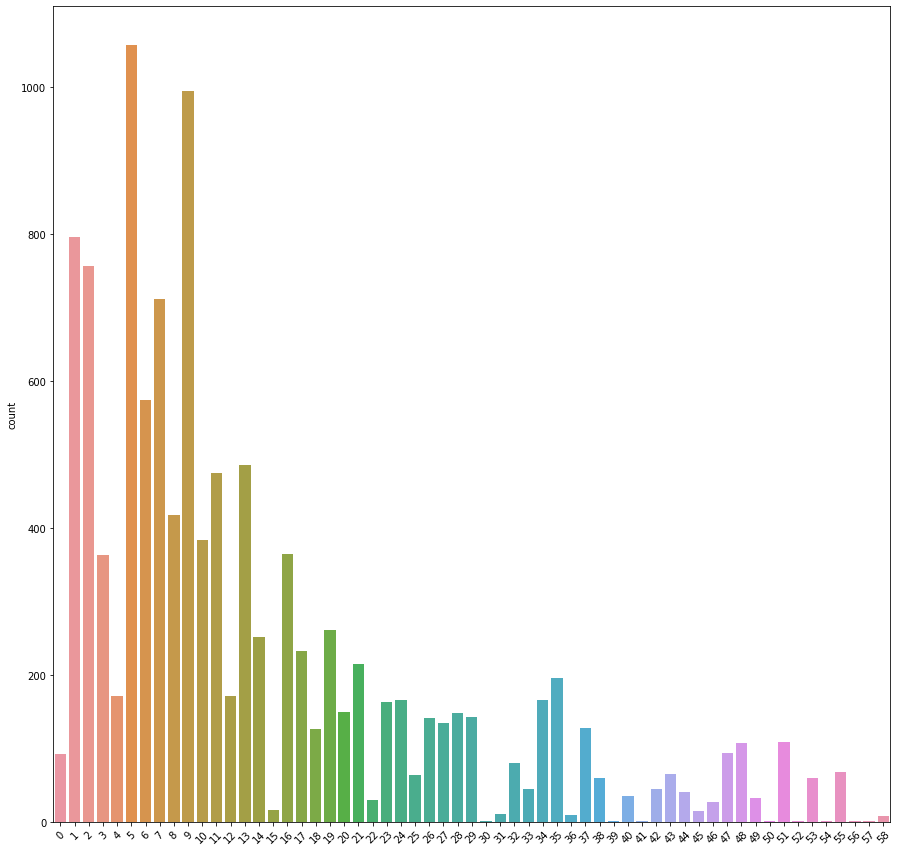

In [ ]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=45)
sns.countplot(x=km59.labels_)

In [ ]:
print(pd.DataFrame(list_vect)[km59.labels_==15].word.head(10))
print('--------------------------------')
print(pd.DataFrame(list_vect)[km59.labels_==10].word.head(10))

273     coño      
286     d         
668     cualquiera
841     cuya      
1902    -que      
2011    mg        
2297    alguien   
2624    xq        
3611    qse       
5133    qu        
Name: word, dtype: object
--------------------------------
21     violación 
24     maltrato  
39     ignorante 
76     servicio  
113    biología  
144    entrada   
162    chinos    
184    paga      
213    baqueros  
219    carreteras
Name: word, dtype: object


#### n_clusters=35

In [ ]:
km35 =KMeans(n_clusters=35, random_state=0).fit(matrix_num)

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(x=km35.labels_)

In [ ]:
print(pd.DataFrame(list_vect)[km35.labels_==15].word.head(10))
print('--------------------------------')
print(pd.DataFrame(list_vect)[km35.labels_==10].word.head(10))

#### DBSCAN para ver optimo de clusters

In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=1.5, min_samples=2).fit(matrix_num)
clustering.labels_

In [ ]:
clustering.labels_.max()

In [ ]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(x=clustering.labels_)

## Embeddings para reduccion de dimensionalidad

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(matrix_num)

In [ ]:
km59_embeddings =KMeans(n_clusters=13, random_state=0).fit(X_embedded)
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(x=km59_embeddings.labels_)

In [ ]:
print(pd.DataFrame(list_vect)[km59_embeddings.labels_==15].word.head(10))
print('--------------------------------')
print(pd.DataFrame(list_vect)[km59_embeddings.labels_==10].word.head(10))

In [ ]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
centroides = km59_embeddings.cluster_centers_
plt.scatter(X_embedded.transpose()[0], X_embedded.transpose()[1],  c="g")
plt.plot(centroides[:,0],centroides[:,1],'mo',markersize=8, label='centroides')

Gran cantidad de palabras que no pertenecen a ningun cluster

In [ ]:
X_embedded = TSNE(n_components=3).fit_transform(matrix_num)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


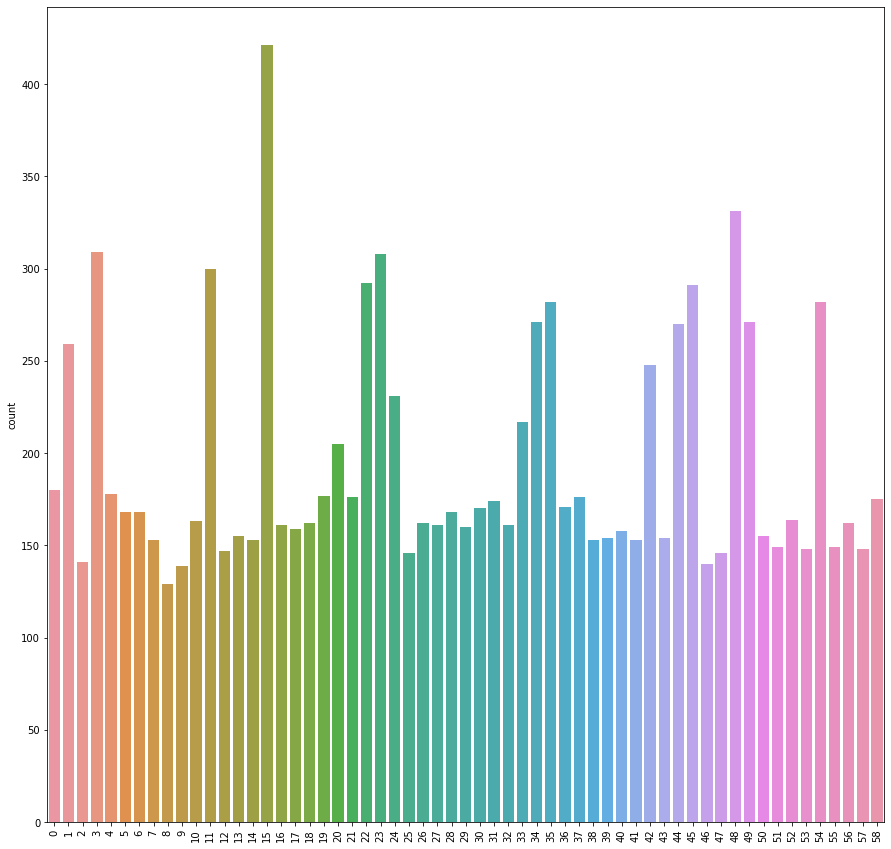

In [ ]:
km59_embeddings_3 =KMeans(n_clusters=59, random_state=0).fit(X_embedded)
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(x=km59_embeddings_3.labels_)

Cambiando el numero de n_components si hay cambios notables

# Point Wise Mutual Information

df_misoginy ya esta limpio

In [ ]:
df_misogyny.tokenized_sentences.iloc[0] 

[gobierno,
 crear,
 control,
 estricto,
 inmigración,
 zonas,
 fronterizas,
 colombia,
 q,
 8querrán,
 venir,
 masa]

In [ ]:
!pip install nltk

In [ ]:
import nltk
import nltk.collocations 
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures
from nltk.corpus import stopwords

In [ ]:
#pongo los twits uno a continuacion del otro
words = []
for sen in df_misogyny.tokenized_sentences:
  aux = [i.text for i in sen] #transformo cada token en texto para que sea string
  words = words+aux

#### Bigramas

In [ ]:
finder_bigramas = BigramCollocationFinder.from_words(words)
bgm = BigramAssocMeasures()
score = bgm.mi_like
Bi_collocations = {'_'.join(bigram): pmi for bigram, pmi in finder_bigramas.score_ngrams(score)}

In [ ]:
Bi_collocations

{'hijo_puta': 18.0787771898883,
 '😂_😂': 14.8877,
 '$_$': 14.8176,
 '😍_😍': 12.301875,
 'guardias_civiles': 11.076923076923077,
 'valla_ceuta': 10.47547974413646,
 'guardia_civil': 10.461904761904762,
 '😭_😭': 9.287981859410431,
 '🇪_🇸': 9.026315789473685,
 '😡_😡': 8.627218934911243,
 '👏_🏼': 8.465608465608465,
 'puta_madre': 7.039972946328266,
 '♀_️': 6.78958944281525,
 'cal_viva': 6.25,
 '😠_😠': 5.333333333333333,
 'efecto_llamada': 4.763888888888889,
 'laiki_laiki': 4.408163265306122,
 '👿_👿': 4.408163265306122,
 'arabia_saudita': 4.166666666666667,
 '❤_️': 4.1623309053069715,
 'norteamericana_advierte': 4.0,
 'open_arms': 4.0,
 '🤦_🏽\u200d': 3.9384615384615387,
 'acoso_sexual': 3.576099706744868,
 '🏼_👏': 3.5714285714285716,
 '😴_😴': 3.4722222222222223,
 '😺_😺': 3.4722222222222223,
 '🏽\u200d_♀': 3.3136363636363635,
 '🤣_🤣': 3.24,
 'inteligencia_norteamericana': 3.2,
 'salvamento_marítimo': 3.2,
 'novia_sevillista': 3.0303030303030303,
 'nuria_vandenberghe': 3.0,
 '💩_💩': 2.834710743801653,
 'emi

In [ ]:
sorted(finder_bigramas.nbest(bgm.raw_freq, 5))

[('a', 'inmigrantes'),
 ('hijo', 'puta'),
 ('puta', 'madre'),
 ('y', 'a'),
 ('😂', '😂')]

In [ ]:
finder_bigramas.apply_freq_filter(10)

In [ ]:
finder_bigramas.nbest(bgm.pmi,-1)

[('guardias', 'civiles'),
 ('cal', 'viva'),
 ('guardia', 'civil'),
 ('🇪', '🇸'),
 ('😠', '😠'),
 ('😭', '😭'),
 ('$', '$'),
 ('novia', 'sevillista'),
 ('😡', '😡'),
 ('👏', '🏼'),
 ('😍', '😍'),
 ('🏼', '👏'),
 ('♀', '️'),
 ('👏', '🏻'),
 ('❤', '️'),
 ('valla', 'melilla'),
 ('emiratos', 'árabes'),
 ('valla', 'ceuta'),
 ('árabes', 'unidos'),
 ('️', '❤'),
 ('inmigración', 'ilegal'),
 ('😂', '😂'),
 ('acoso', 'sexual'),
 ('inmigrantes', 'ilegales'),
 ('  ', 'callate'),
 ('hijo', 'puta'),
 ('hija', 'puta'),
 ('puta', 'idea'),
 ('inmigrantes', 'subsaharianos'),
 (' ', 'vía'),
 ('puta', 'madre'),
 ('acoso', 'violación'),
 ('callate', 'hijo'),
 ('hijos', 'puta'),
 ('puta', 'boca'),
 ('vía', ' '),
 ('  ', 'cállate'),
 (' ', 'm'),
 ('o', 'violación'),
 ('ayudar', 'a'),
 ('cállate', 'perra'),
 ('violación', 'o'),
 ('vete', 'a'),
 ('iba', 'a'),
 ('re', 'puta'),
 ('hijo', 'perra'),
 ('vas', 'a'),
 (' ', 'callate'),
 ('cállate', 'puta'),
 (' ', 'cállate'),
 ('o', 'acoso'),
 ('frente', 'a'),
 ('tienes', 'puta'),
 ('

#### Trigramas

In [ ]:
finder_trigramas = TrigramCollocationFinder.from_words(words)
tgm = TrigramAssocMeasures()
score = tgm.mi_like
Tri_collocations = {'_'.join(trigram): pmi for trigram, pmi in finder_trigramas.score_ngrams(score)}

In [ ]:
Tri_collocations

{'-""las_previsiones_apuntan': 1.0,
 '-dijo_jadeando_oreja': 1.0,
 '-¡ah_sección_ciencia': 1.0,
 '.@pnud_ods16_lograr': 1.0,
 '1!he_sacado_voh': 1.0,
 '16/01/2018_padrinos_david': 1.0,
 '1606,se_fundó_bayaguana': 1.0,
 '19dhul_qhui_dah': 1.0,
 '1º_renovar_residencia': 1.0,
 '2)defendemos_idioteces_3)nos': 1.0,
 '22:30_hrs_revive': 1.0,
 '22h_vidto_quitaste': 1.0,
 '3)nos_creemos_progresistas': 1.0,
 '4x4_toyota_crazy': 1.0,
 'abid_acompañaranos_neste': 1.0,
 'abon_candesita_cuale': 1.0,
 'aborrece_escorias_mico': 1.0,
 'acabose_colonialismo_proximidad': 1.0,
 'accesorios_carteras_zapatos': 1.0,
 'aceptas_cesta_ticket': 1.0,
 'acepte_cortesías_ánimos': 1.0,
 'acordaba_antisistema_podemita=': 1.0,
 'actocriminal_entwitter_muérete': 1.0,
 'adinerados_masones_judas': 1.0,
 'adjuntarle_jota_inventada': 1.0,
 'adornada_consumismo_teñida': 1.0,
 'afasa_lena_dunham': 1.0,
 'afiliado_blandengue_mocho': 1.0,
 'afirmación_alertaporhijodeputa_alertacabronazo': 1.0,
 'afueras_suburbano_lechería': 1

In [ ]:
sorted(finder_trigramas.nbest(tgm.raw_freq, 2))

[('😂', '😂', '😂'), ('😍', '😍', '😍')]

In [ ]:
finder_trigramas.apply_freq_filter(10)

In [ ]:
finder_trigramas.nbest(tgm.pmi, -1)

[('😭', '😭', '😭'),
 ('$', '$', '$'),
 ('😡', '😡', '😡'),
 ('emiratos', 'árabes', 'unidos'),
 ('😍', '😍', '😍'),
 ('👏', '🏼', '👏'),
 ('❤', '️', '❤'),
 ('️', '❤', '️'),
 ('😂', '😂', '😂'),
 ('cállate', 'puta', 'boca'),
 ('callate', 'puta', 'boca'),
 ('callate', 'hijo', 'puta'),
 (' ', 'vía', ' '),
 ('acoso', 'y', 'violación')]

# Point Wise Mutual Information contra la clase de odio contra mujeres

In [ ]:
df_genre_insults = df_misogyny[df_misogyny.genre_insults]

In [ ]:
bigram_list = finder_bigramas.nbest(tgm.pmi, -1)
trigram_list = finder_trigramas.nbest(tgm.pmi, -1)

In [ ]:
#pongo los twits uno a continuacion del otro
sen_bigram = []
sen_trigram = []
sen_bigram_g = []
sen_trigram_g =[]
for sen in df_misogyny.tokenized_sentences:
  aux = [i.text for i in sen] #transformo cada token en texto para que sea string
  
  finder_bigramas = BigramCollocationFinder.from_words(aux)
  bgm = BigramAssocMeasures()
  score = bgm.mi_like
  Bi_collocations = {'_'.join(bigram): pmi for bigram, pmi in finder_bigramas.score_ngrams(score)}
  sen_bigram.append(finder_bigramas.nbest(bgm.pmi, -1))

  finder_trigramas = TrigramCollocationFinder.from_words(aux)
  tgm = TrigramAssocMeasures()
  score = tgm.mi_like
  Tri_collocations = {'_'.join(trigram): pmi for trigram, pmi in finder_trigramas.score_ngrams(score)}
  sen_trigram.append(finder_trigramas.nbest(tgm.pmi, -1))

for sen in df_genre_insults.tokenized_sentences:
  aux = [i.text for i in sen] #transformo cada token en texto para que sea string
  
  finder_bigramas = BigramCollocationFinder.from_words(aux)
  bgm = BigramAssocMeasures()
  score = bgm.mi_like
  Bi_collocations = {'_'.join(bigram): pmi for bigram, pmi in finder_bigramas.score_ngrams(score)}
  sen_bigram_g.append(finder_bigramas.nbest(bgm.pmi, -1))

  finder_trigramas = TrigramCollocationFinder.from_words(aux)
  tgm = TrigramAssocMeasures()
  score = tgm.mi_like
  Tri_collocations = {'_'.join(trigram): pmi for trigram, pmi in finder_trigramas.score_ngrams(score)}
  sen_trigram_g.append(finder_trigramas.nbest(tgm.pmi, -1))

In [ ]:
bigram_score=[]
for k in bigram_list:
  EinC=0
  EinU=0
  for i in sen_bigram_g :
    EinC += k in i
  for j in sen_bigram :
    EinU += k in j
  if EinU ==0:
    bigram_score.append(0)
  else:
    bigram_score.append(EinC/(EinU*len(sen_bigram_g)))

trigram_score=[]
for k in trigram_list:
  EinC=0
  EinU=0
  for i in sen_trigram_g :
    EinC += k in i
  for j in sen_trigram :
    EinU += k in j
  if EinU ==0:
    trigram_score.append(0)
  else:
    trigram_score.append(EinC/(EinU*len(sen_trigram_g)))

In [ ]:
ngram=bigram_list
ngram.extend(trigram_list)
pmi=bigram_score
pmi.extend(trigram_score)

In [ ]:
pd.DataFrame(data={'ngram':ngram,'pmi':pmi})

,ngram,pmi
0,"(guardias, civiles)",0.000141
1,"(cal, viva)",0.000000
2,"(guardia, civil)",0.000130
3,"(🇪, 🇸)",0.000212
4,"(😠, 😠)",0.000847
...,...,...
103,"(cállate, puta, boca)",0.000847
104,"(callate, puta, boca)",0.000847
105,"(callate, hijo, puta)",0.000847
106,"( , vía, )",0.000000


# Point Wise Mutual Information Gender

In [ ]:
#pongo los twits uno a continuacion del otro
hate_words = []
for sen in df_misogyny.tokenized_sentences[(df_misogyny.genre_insults) & (df_misogyny.AG==1)]:
  aux = [i.text for i in sen] #transformo cada token en texto para que sea string
  hate_words = hate_words+aux

#### Bigramas

In [ ]:
finder_bigramas = BigramCollocationFinder.from_words(hate_words)
bgm = BigramAssocMeasures()
score = bgm.mi_like
Bi_collocations = {'_'.join(bigram): pmi for bigram, pmi in finder_bigramas.score_ngrams(score)}

In [ ]:
Bi_collocations

{'😂_😂': 7.438775510204081,
 '👿_👿': 4.408163265306122,
 '💩_💩': 3.4722222222222223,
 '😺_😺': 3.4722222222222223,
 'doble_moral': 3.0,
 'hija_puta': 2.670272358508789,
 '😡_😡': 2.6666666666666665,
 '👋_👋': 2.56,
 '😛_😛': 2.56,
 'chugar_daddy': 2.0,
 'espejo_recuerda': 2.0,
 'recuerda_agil': 2.0,
 '😢_😢': 1.6875,
 ' _cállate': 1.4415720891130728,
 'aa_brii': 1.3333333333333333,
 '🤦_🏻\u200d': 1.3333333333333333,
 '-sin_eta': 1.0,
 '-un_corte': 1.0,
 '-veis_chicas': 1.0,
 '1er_grado': 1.0,
 '<_brava': 1.0,
 'abc.vete_delincuente': 1.0,
 'abdala_bucaram': 1.0,
 'abon_candesita': 1.0,
 'abres_saves': 1.0,
 'abrir_piernas': 1.0,
 'absolutamente_racisimo': 1.0,
 'aceptas_cesta': 1.0,
 'aclaren_revela': 1.0,
 'acoges_vacaciones': 1.0,
 'actitud_altanera': 1.0,
 'acumular_añonuevoencombate': 1.0,
 'adjuntarle_jota': 1.0,
 'agarre_gendarme': 1.0,
 'agradece_tire': 1.0,
 'agredecerá_sacrificio': 1.0,
 'alba_bajini': 1.0,
 'albert_haremos': 1.0,
 'alcongresoporlosjubilados_carrio': 1.0,
 'alegro_jajaj': 1

In [ ]:
sorted(finder_bigramas.nbest(bgm.raw_freq, 5))

[(' ', 'cállate'), ('hija', 'puta'), ('puta', 'y'), ('zorra', 'y'), ('😂', '😂')]

Más de 10 apariciones

In [ ]:
finder_bigramas.apply_freq_filter(10)

Las mejores 20

In [ ]:
finder_bigramas.nbest(bgm.pmi, 20)

[('😂', '😂'),
 ('hija', 'puta'),
 (' ', 'cállate'),
 ('cállate', 'perra'),
 ('zorra', 'y'),
 ('puta', 'y')]

#### Trigramas

In [ ]:
finder_trigramas = TrigramCollocationFinder.from_words(words)
tgm = TrigramAssocMeasures()
score = tgm.mi_like
Tri_collocations = {'_'.join(trigram): pmi for trigram, pmi in finder_trigramas.score_ngrams(score)}

In [ ]:
Tri_collocations

{'-""las_previsiones_apuntan': 1.0,
 '-dijo_jadeando_oreja': 1.0,
 '-¡ah_sección_ciencia': 1.0,
 '.@pnud_ods16_lograr': 1.0,
 '1!he_sacado_voh': 1.0,
 '16/01/2018_padrinos_david': 1.0,
 '1606,se_fundó_bayaguana': 1.0,
 '19dhul_qhui_dah': 1.0,
 '1º_renovar_residencia': 1.0,
 '2)defendemos_idioteces_3)nos': 1.0,
 '22:30_hrs_revive': 1.0,
 '22h_vidto_quitaste': 1.0,
 '3)nos_creemos_progresistas': 1.0,
 '4x4_toyota_crazy': 1.0,
 'abid_acompañaranos_neste': 1.0,
 'abon_candesita_cuale': 1.0,
 'aborrece_escorias_mico': 1.0,
 'acabose_colonialismo_proximidad': 1.0,
 'accesorios_carteras_zapatos': 1.0,
 'aceptas_cesta_ticket': 1.0,
 'acepte_cortesías_ánimos': 1.0,
 'acordaba_antisistema_podemita=': 1.0,
 'actocriminal_entwitter_muérete': 1.0,
 'adinerados_masones_judas': 1.0,
 'adjuntarle_jota_inventada': 1.0,
 'adornada_consumismo_teñida': 1.0,
 'afasa_lena_dunham': 1.0,
 'afiliado_blandengue_mocho': 1.0,
 'afirmación_alertaporhijodeputa_alertacabronazo': 1.0,
 'afueras_suburbano_lechería': 1